# Library

In [2]:
#preprocessing data
import os
import pandas as pd
import matplotlib.pyplot as plt

#split data
from sklearn.model_selection import train_test_split
import pickle

#handling imbalanced data
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

#feauture extraction Layer
from tensorflow.keras.layers import TextVectorization
import numpy as np

#Model Architecture
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Activation
from tensorflow.keras.utils import plot_model

#Model Compiler
from tensorflow.keras import optimizers
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, MeanSquaredError, AUC

#Model Training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

#report evaluation model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#load model
from keras.models import load_model

In [3]:
import tensorflow as tf

In [4]:
a = tf.constant([1, 2, 3, 4, 5, 6], shape=[2, 3])
a  # 2-D tensor
b = tf.constant([7, 8, 9, 10, 11, 12], shape=[3, 2])
b  # 2-D tensor
c = tf.matmul(a, b)
c  # `a` * `b`

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 58,  64],
       [139, 154]])>

# Preprocessing Data

## Import Data

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
current_directory = os.path.dirname(os.path.abspath("LSTM.ipynb"))

In [4]:
df_train = pd.read_csv(current_directory + "\\Clean_dataset\\Clean_train_preprocess.csv")
df_train.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung dimiliki pengusaha pabrik tahu puluhan ...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k mmbri hujjah pak ai apa ha...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung tempat ...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia diri unboxing paket barang bagu...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh jadi mahasiswa jangan sombong dong kasih ...


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10933 entries, 0 to 10932
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        10933 non-null  object
 1   label       10933 non-null  object
 2   text_clean  10933 non-null  object
dtypes: object(3)
memory usage: 256.4+ KB


In [6]:
df_train['label'].value_counts()

label
positive    6383
negative    3412
neutral     1138
Name: count, dtype: int64

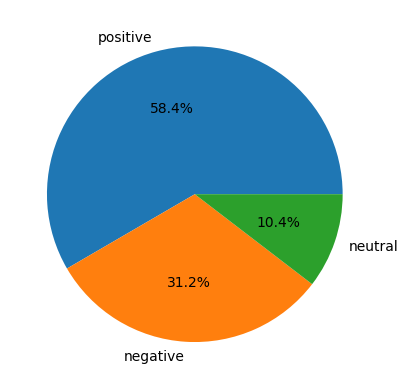

In [7]:
plt.pie([6383, 3412, 1138], labels= ['positive', 'negative', 'neutral'], autopct='%1.1f%%')
plt.show()

## Sort Data from Label 

In [8]:
neg = df_train.loc[df_train['label'] == 'negative'].text_clean.tolist()
neu = df_train.loc[df_train['label'] == 'neutral'].text_clean.tolist()
pos = df_train.loc[df_train['label'] == 'positive'].text_clean.tolist()

neg_label = df_train.loc[df_train['label'] == 'negative'].label.tolist()
neu_label = df_train.loc[df_train['label'] == 'neutral'].label.tolist()
pos_label = df_train.loc[df_train['label'] == 'positive'].label.tolist()

In [9]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('Pos: %s, Neu: %s, Neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(total_data))

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


## Split Data

In [10]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [12]:
data_text = df_train[['text_clean']]
labels = df_train['label']

In [16]:
X_train, X_ass, y_train, y_ass = train_test_split(data_text, labels, test_size=0.4, random_state=42)

In [17]:
X_test, X_valid, y_test, y_valid = train_test_split(X_ass, y_ass, test_size=0.5, random_state=42)

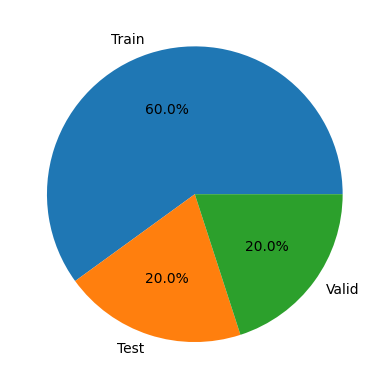

In [24]:
plt.pie([len(X_train), len(X_test), len(X_valid)], 
        labels=['Train', 'Test', 'Valid'], 
        autopct='%1.1f%%')
plt.show()

## Handling Imbalanced Data Training

In [25]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

In [26]:
Counter(y_train)

Counter({'positive': 3805, 'negative': 2055, 'neutral': 699})

In [27]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

ROS = RandomOverSampler()
X_train_ros, y_train_ros = ROS.fit_resample(X_train, y_train)

In [28]:
Counter(y_train_ros)

Counter({'positive': 3805, 'negative': 3805, 'neutral': 3805})

# TextVectorization (Encoder)

In [15]:
import pickle
from tensorflow.keras.layers import TextVectorization
import numpy as np

In [50]:
max_features = 10000

#Create Layer
encoder = TextVectorization(max_tokens=max_features, 
                            split='whitespace', 
                            standardize='lower')
                            # output_mode='tf_idf')
                            # pad_to_max_tokens=True)
encoder.adapt(X_train_ros.text_clean.tolist())

In [51]:
vocab = np.array(encoder.get_vocabulary())
vocab[:10]

array(['[UNK]', 'tidak', 'makanan', 'enak', 'tempat', 'makan', 'sangat',
       'harga', 'bisa', 'sini'], dtype='<U26')

In [20]:
X_train = np.array(X_train)

In [33]:
X_valid = np.array(X_valid)

In [34]:
X_test = np.array(X_test)

In [35]:
y_train = pd.get_dummies(y_train_ros)
y_train = y_train.values

In [36]:
y_valid = pd.get_dummies(y_valid)
y_valid = y_valid.values

In [37]:
y_test = pd.get_dummies(y_test)
y_test = y_test.values

# Training Model LSTM

In [38]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.utils import plot_model

## Architecture

In [52]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.utils import plot_model

length_input = len(encoder.get_vocabulary())
length_output = 100

model = Sequential()
model.add(encoder)
model.add(Embedding(input_dim=length_input, 
                    output_dim=length_output))
model.add(LSTM(64, dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [40]:
# plot_model(model, to_file = "model.png", show_shapes=True)

## Compile

In [41]:
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

In [53]:
model.compile(optimizer = optimizers.Adam(learning_rate=0.001), 
              loss= CategoricalCrossentropy(), 
              metrics= ['Accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 10000)             1         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 10000, 100)        1000000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                      

In [43]:
model.evaluate(X_train, y_train)


357/357 [==============================] - 11s 17ms/step - loss: 1.0985 - Accuracy: 0.3338


[1.0984565019607544, 0.33377134799957275]

In [54]:
model.evaluate(X_valid, y_valid)

69/69 [==============================] - 164s 2s/step - loss: 1.0914 - Accuracy: 0.3091


[1.0914348363876343, 0.3090992271900177]

## Train The Model

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

In [46]:
my_callbacks = [
    EarlyStopping(monitor='val_loss', patience = 5, verbose=1)
    # ReduceLROnPlateau(patience = 4)
]

In [47]:
history = model.fit(X_train, 
                    y_train,
                    batch_size = 32,
                    epochs=20,
                    validation_data=(X_valid, y_valid),
                    verbose=1,
                    callbacks=my_callbacks)

Epoch 1/20
357/357 [==============================] - 33s 68ms/step - loss: 0.8687 - Accuracy: 0.5613 - val_loss: 0.8201 - val_Accuracy: 0.6118
Epoch 2/20
357/357 [==============================] - 24s 67ms/step - loss: 0.8232 - Accuracy: 0.6176 - val_loss: 0.7971 - val_Accuracy: 0.6269
Epoch 3/20
357/357 [==============================] - 20s 55ms/step - loss: 0.6613 - Accuracy: 0.7200 - val_loss: 0.6312 - val_Accuracy: 0.7609
Epoch 4/20
357/357 [==============================] - 27s 74ms/step - loss: 0.3327 - Accuracy: 0.9076 - val_loss: 0.6685 - val_Accuracy: 0.8139
Epoch 5/20
357/357 [==============================] - 21s 58ms/step - loss: 0.2472 - Accuracy: 0.9435 - val_loss: 0.7250 - val_Accuracy: 0.7965
Epoch 6/20
357/357 [==============================] - 24s 66ms/step - loss: 0.1661 - Accuracy: 0.9603 - val_loss: 0.8949 - val_Accuracy: 0.7979
Epoch 7/20
357/357 [==============================] - 23s 64ms/step - loss: 0.1412 - Accuracy: 0.9646 - val_loss: 0.8310 - val_Accuracy:

## Train, Validation Loss & Accuracy Curve

In [121]:
import matplotlib.pyplot as plt

In [122]:
def plot_history(history):
    plt.style.use('ggplot')
    
    acc = history.history['Accuracy']
    val_acc = history.history['val_Accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training & Validation Accuracy')
    plt.ylim([0, 1])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training & Validation Loss')
    plt.ylim([0, 1])
    plt.legend()
    
    plt.savefig('image.png')

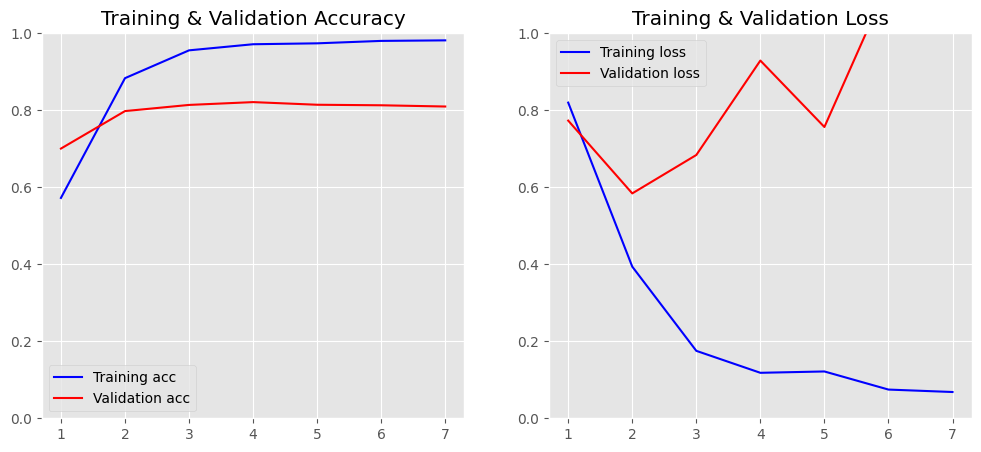

In [137]:
%matplotlib inline
plot_history(history)

In [88]:
model.save("model_10.keras", save_format="keras")

# Evaluation

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [124]:
model.evaluate(X_test, y_test)

69/69 [==============================] - 1s 11ms/step - loss: 1.1259 - Accuracy: 0.8281


[1.1258544921875, 0.8280749917030334]

In [139]:
prediction = model_LSTM.predict(X_test)
y_pred = prediction

matrix_test = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing Selesai')
print(matrix_test)

69/69 [==============================] - 1s 12ms/step
Testing Selesai
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       681
           1       0.90      0.24      0.38       230
           2       0.79      0.95      0.86      1276

    accuracy                           0.80      2187
   macro avg       0.83      0.63      0.66      2187
weighted avg       0.81      0.80      0.78      2187



In [26]:
class_names = ['Negative', 'Neutral', 'Positive']

69/69 [==============================] - 3s 13ms/step


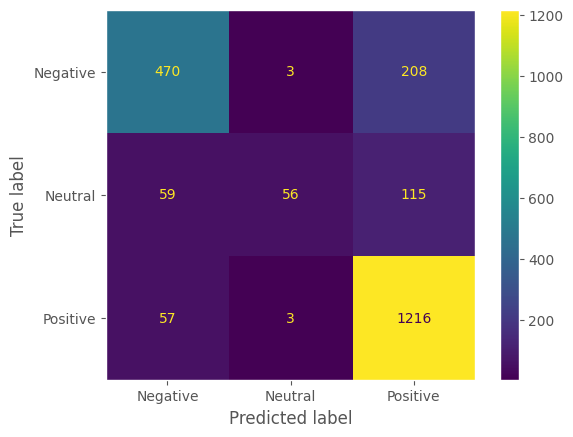

In [138]:
prediction = model.predict(X_test)
y_pred = prediction
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

disp.plot()
plt.grid(False)
plt.savefig('matrix_10.png')
plt.show()

# Implement Model to New Dataset

## import new data (tweet)

In [8]:
import pandas as pd

In [9]:
df = pd.read_csv(current_directory + "\\Clean_dataset\\Clean_data_Tweet.csv")
df.head()

,Tweet
0,di saat semua cowok berusaha melacak perhatian...
1,siapa telat memberi kamu edan sarap bergaul ci...
2,kadang aku berpikir aku tetap percaya tuhan pa...
3,aku aku matamu sipit tapi dilihat mana aku
4,kaum cebong kafir kelihatan dongoknya awal tam...


In [10]:
df_tweet= pd.DataFrame(df[['Tweet']])
df_tweet.head()

,Tweet
0,di saat semua cowok berusaha melacak perhatian...
1,siapa telat memberi kamu edan sarap bergaul ci...
2,kadang aku berpikir aku tetap percaya tuhan pa...
3,aku aku matamu sipit tapi dilihat mana aku
4,kaum cebong kafir kelihatan dongoknya awal tam...


In [11]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12794 entries, 0 to 12793
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   12794 non-null  object
dtypes: object(1)
memory usage: 100.1+ KB


# Prediction

In [1]:
import os
import re
import json
import numpy as np
from keras.models import load_model
from collections import Counter

In [2]:
current_directory = os.path.dirname(os.path.abspath("LSTM.ipynb"))

In [3]:
model_LSTM = load_model(r"E:\BINAR\Platinum-Challenge\Neural_Network_LSTM\model_LSTM.keras")

In [4]:
list_sentiment = ['negative', 'neutral', 'positive']

In [5]:
def LSTM_CSV_prediction(df):
    Data = np.array(df.Tweet)
    prediction = model_LSTM.predict(Data, batch_size=32)

    label = []
    for i in range(len(prediction)):
        polarity = np.argmax(prediction[i])
        sentiment = list_sentiment[polarity]

        label.append(sentiment)
    jsonList = []
    for i in range(len(Data)):
        jsonList.append({"Tweet" : Data[i], "Label" : label[i]})
    return jsonList

In [ ]:
json_final = LSTM_CSV_prediction(df_tweet)

400/400 [==============================] - 6s 12ms/step


In [26]:
json_final[:5]

[{'Tweet': 'di saat semua cowok berusaha melacak perhatian kamu lantas remehkan perhatian kasih khusus kamu basic kamu cowok bego',
  'Label': 'negative'},
 {'Tweet': 'siapa telat memberi kamu edan sarap bergaul cigax jifla calis sama siapa licew',
  'Label': 'negative'},
 {'Tweet': 'kadang aku berpikir aku tetap percaya tuhan padahal aku selalu jatuh berkali kali kadang aku merasa tuhan meninggalkan aku sendirian orang tuaku berencana berpisah kakakku lebih memilih jadi kristen aku anak ter',
  'Label': 'positive'},
 {'Tweet': 'aku aku matamu sipit tapi dilihat mana aku', 'Label': 'positive'},
 {'Tweet': 'kaum cebong kafir kelihatan dongoknya awal tambah dungu haha',
  'Label': 'negative'}]

## json dump

In [ ]:
json_akhir = json.dumps(json_final, indent = 1)

In [29]:
# Writing to sample.json
# with open("hasil_json.json", "w") as outfile:
#     outfile.write(json_final)

In [ ]:
# df = pd.read_json('hasil_json.json')
# df.head()